# Mode fitting

Here we will make a simple hierarchical model that encodes some knowledge of quasi-equally spaced modes of oscillation into the prior.

We will also add a Guassian Process prior over the linewidths

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

Let's set up the data first.  We will define a bunch of Lorentzian modes that are nearly equaly space in frequency.  The mode heights will be controlled by a Gaussian function. 

So the mode frequencies will be defined as:

$f_{n, {\rm true}} = (n + 0.5) \Delta \nu + \mathcal{N}(0, 0.02)$.

and the envelope will just be:

$H_n = 25.0 \exp(-0.5 (f_{n, {\rm true}} - \nu_{\rm max})^2 / 5^2)$

The data are then just the model of the sum of the Lorentzians, evaluated a frequencies $f_{i}$, plus 1.  To the data we add Gaussian noise (to keep things simple) with mean zero and standard deviation of unity.

We have the mode linewidth vary as a function of mode frequency.  There are lots of relations but let's just make a simple power law for now.

$\Gamma_{n} = 10^{\alpha + f_{n} \beta}$

and we will use the parameters $\alpha = -1.7$ and $\beta=5\times10^{-2}$.

Text(0.5, 0, 'Frequnency')

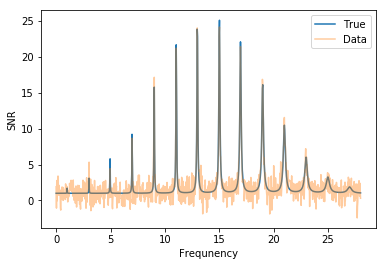

In [2]:
def lw(f0, alpha=-1.7, beta=5e-2):
    return 10**(alpha + f0 * beta)

def lor(f, f0, w, h):
    return h / (1.0 + 4.0 * ((f - f0)/w)**2)

def gaussian(f, f0, h, w):
    return h * np.exp(-0.5 * (f - f0)**2 / w**2)

np.random.seed(53)
f = np.linspace(0, 28, 1000)
dnu = 2.0
numax = 14.0
f0s = (np.arange(0, 14, 1) + 0.5) * dnu 
f0s += + np.random.randn(len(f0s)) * 0.02
true = np.ones(len(f))
true += np.sum([lor(f, n, lw(n), gaussian(n, numax, 25.0, 5.0)) for n in f0s], axis=0)
#data = true * np.random.chisquare(2, len(true)) / 2.0
data = true + np.random.randn(len(true))
fig, ax = plt.subplots()
ax.plot(f, true, label='True', zorder=0)
ax.plot(f, data, label='Data', alpha=0.4)
ax.legend()
ax.set_ylabel('SNR')
ax.set_xlabel('Frequnency')

Now we look at a GP to describe the linewidth.

Below I give a very simple (and unstable) implementation of a GP.  If you were doing this for real you would want to use the log likelihood and use the slogdet function for increased stability.

The kernel is the standard squared exponential.  Other kernels are available.

If you adjust the values in theta you will see how the GP reacts.   This implementation takes no acocunt of any uncertainty in the line width.  This is similar to what we want - as we apply the GP as a prior over linewidth as a function of frequency we will be running the prior on the proposed parameters which are exact values.

One needs to be careful in interpreting how the two kernel parameters impact the actual prior that is being used.  To really inspect this dependency you can simply construct a kernel and the draw random deviates from the mean=0 and covariance matrix from the kernel.  Plotting the simply the array of a single draw in rank order will produce one function drawn from what we are using as our prior.

/home/davies/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


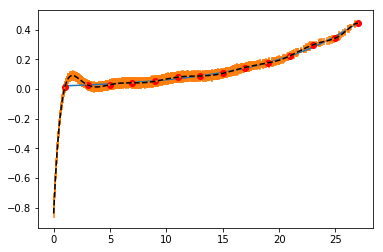

In [17]:
fig, ax = plt.subplots()
ax.plot(f0s, lw(f0s))

def kernel(x, y, p):
    # p[0] = sigma
    # p[1] = length scale
    return p[0]**2 * np.exp(-0.5 * np.subtract.outer(x, y)**2 / p[1]**2)

def like(y1, A):
    return (2.0 * np.pi * np.linalg.det(A))**-0.5 * np.exp(-0.5 * np.dot(y1, np.linalg.pinv(A)).dot(y1.T))

def predict(t_2, t_1, kernel, p, y_1):
    B = kernel(t_1, t_2, p).T
    C = kernel(t_2, t_2, p)
    A = kernel(t_1, t_1, p)
    Ainv = np.linalg.pinv(A)
    y_pred = np.dot(B, Ainv).dot(y_1)
    sigma_new = C - np.dot(B, Ainv).dot(B.T)
    return y_pred, np.diagonal(sigma_new)**0.2

t_1= f0s
y_1 = lw(f0s) + np.random.randn(len(f0s)) * 0.01
t_2 = np.linspace(0, 27, 2000)
theta = [0.01, 10.0]
y_pred, sigmas = predict(t_2, t_1, kernel, theta, y_1)

ax.errorbar(t_2, y_pred, yerr=sigmas, capsize=0)
ax.plot(t_2, y_pred, 'k--', zorder=99)
ax.plot(t_1, y_1, 'ro')

And here is some Stan code that we can use to fit the kernel parameters of the GP.  

Note the speed up by using the cholesky decomposition is very modest for a dataset of this size.

In [170]:
code = '''
data {
    int N;
    real f[N];
    vector[N] lw;
    vector[N] mu;
}
parameters {
    real<lower=0> rho;
    real<lower=0> alpha;
}
model {
    matrix[N, N] cov =   cov_exp_quad(f, alpha, rho)
                     + diag_matrix(rep_vector(1e-10, N));
    matrix[N, N] L_cov = cholesky_decompose(cov);
    alpha ~ normal(0, 10);
    rho ~ normal(0, 10);
    lw ~ multi_normal_cholesky(mu, L_cov);
}

'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_98a1f0d837c76ddc0b6cdbff6ce0dcb9 NOW.


In [171]:
data = {'N': len(t_1), 'f': t_1, 'lw': y_1, 'mu': np.zeros(len(t_1))}
fit = sm.sampling(data=data, iter=20000, chains=4)

/home/davies/.local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


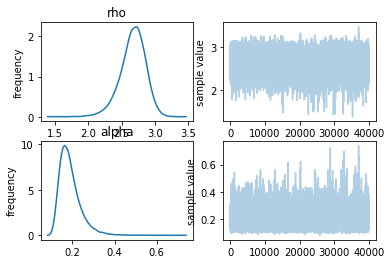

In [172]:
fit.plot()
plt.show()

In [173]:
print(fit)

Inference for Stan model: anon_model_98a1f0d837c76ddc0b6cdbff6ce0dcb9.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho     2.67  1.7e-3   0.19   2.25   2.56   2.68    2.8    3.0  12079    1.0
alpha   0.19  4.7e-4   0.05   0.12   0.15   0.18   0.21   0.31  11617    1.0
lp__   26.73    0.01   1.09  23.81  26.31  27.06  27.51  27.79  11254    1.0

Samples were drawn using NUTS at Wed Nov 14 17:40:10 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


We now transform the data into a ladder, or echelle, with one mode in each segment.  This is now the same as in Problem 5.  

(Note you may need to regenerate the data because I think I reuse a variable of something in the GP stuff above)

In [176]:
bin_width = f[1] - f[0]
w = int(dnu / bin_width)
s = 0
h = int(np.floor(len(data[s:]) / w))
ladder_p = np.reshape(data[s:h*w+s], [h, w])
ladder_f = np.reshape(f[s:h*w+s], [h, w])

We can collapse the echelle and combine with some smoothing techniques to show you the data:

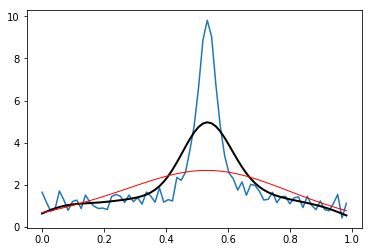

In [177]:
from astropy.convolution import Gaussian1DKernel, convolve
fig, ax = plt.subplots()
ax.plot(ladder_f[0,:] / dnu, np.mean(ladder_p, axis=0))
# Create kernel
g = Gaussian1DKernel(stddev=5)
# Convolve data
z = convolve(np.mean(ladder_p, axis=0), g)
ax.plot(ladder_f[0,:] / dnu, z, 'k-', lw=2)
# Create kernel
g = Gaussian1DKernel(stddev=15)
# Convolve data
z = convolve(np.mean(ladder_p, axis=0), g)
ax.plot(ladder_f[0,:] / dnu, z, 'r-', lw=1)

In [178]:
n_max = numax / dnu
nn = 14
d_f = ladder_f[0,:] / dnu

Now we can plot the uncollapsed echelle:

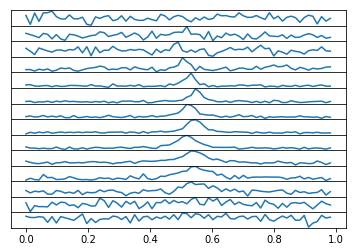

In [179]:
fig, ax = plt.subplots(nn)
for i in range(int(nn)):
        ax[i].plot(d_f, ladder_p[i,:], label=f'Index: {i}')
        ax[i].set_yticks([])        
plt.subplots_adjust(hspace=0.0, wspace=0.0)

And now we build the example Pystan model:

In [181]:
code = '''
functions {
    real lor(real freq, real f0, real w, real h){
        return h / (1 + 4 * ((freq - f0)/w)^2);
    }
    real gaussian(real f, real numax, real width, real height){
        return height * exp(-0.5 * (f - numax)^2 / width^2);
    }
}
data {
    int N; // Data points per order
    int M; // Number of orders
    real freq[M, N];
    real snr[M, N];
    real dnu_est;
    real numax_est;
    vector[M] mu;
    real lw_rho;
    real lw_alpha;
}
parameters {
    real<lower = 0> dnu;
    real<lower = 0> numax;
    real<lower = 0> envwidth;
    real<lower = 0> envheight;
    vector<lower = 0>[M] modewidth;
    real delta[M];
    real<lower = 0> scale;
}
transformed parameters {
    real mode_freqs[M];
    real mode_heights[M];
    for (i in 1:M){
        mode_freqs[i] = (i-0.5) * dnu + delta[i] * scale;
        mode_heights[i] = gaussian(mode_freqs[i], numax, envwidth, envheight);
    }
}
model {
    real beta[N];
    matrix[M, M] cov;
    for (i in 1:M){
        for (j in 1:N){
            beta[j] =  (1.0 + lor(freq[i, j], mode_freqs[i], modewidth[i], mode_heights[i]));
        }
        snr[i, :] ~ normal(beta, 1.0);
    }
    // GP prior over the linewidth function
    cov = cov_exp_quad(mode_freqs, lw_alpha, lw_rho) + diag_matrix(rep_vector(1e-6, M));
    modewidth ~ multi_normal(mu, cov);
    // Carry on
    dnu ~ normal(dnu_est, dnu_est * 0.01);
    dnu ~ uniform(dnu_est * 0.9, dnu_est * 1.1);
    numax ~ normal(numax_est, numax_est * 0.01);
    numax ~ uniform(numax_est * 0.9, numax_est * 1.1);
    envwidth ~ normal(5.0, 1.0);
    envheight ~ normal(25.0, 3.0);
    modewidth ~ lognormal(log(0.1), 1.5);
    delta ~ normal(0, 1); 
    scale ~ normal(0, 0.01);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d4b9c98b2154113771d7b739aadb7f5d NOW.


The code takes a while to converge.  We run for 20000 iterations and check the results.

In [182]:
stan_data = {'N': len(ladder_f[0,:]), 'M': len(ladder_p[:,0]), 
             'freq': ladder_f, 'snr': ladder_p,
            'dnu_est': dnu, 'numax_est': numax, 
             'mu': np.zeros(len(ladder_p[:,0])),
            'lw_rho': 6.0, 'lw_alpha': 0.5}
nchains = 4
start = {'dnu': dnu, 'numax': numax, 
         'delta': np.random.randn(len(ladder_p[:,0])), 
         'scale': 0.01,
         'modewidth': np.ones(len(ladder_p[:,0])) * 0.1}
fitsm = sm.sampling(data=stan_data, iter=4000, chains=nchains, init=[start for n in range(nchains)])

/home/davies/.local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


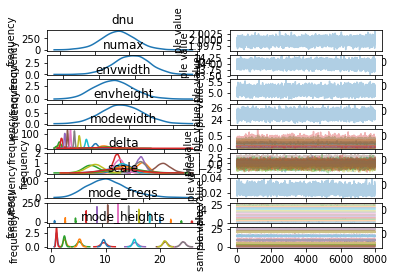

In [183]:
fitsm.plot()
plt.show()

In [184]:
print(fitsm)

Inference for Stan model: anon_model_d4b9c98b2154113771d7b739aadb7f5d.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu                 2.0  2.1e-5 1.0e-3    2.0    2.0    2.0    2.0    2.0   2282    1.0
numax             13.98  1.4e-3    0.1  13.78  13.92  13.98  14.05  14.17   4782   1.01
envwidth            5.1  1.8e-3   0.11   4.89   5.02    5.1   5.17   5.33   3745    1.0
envheight         24.84  6.6e-3   0.46  23.96  24.53  24.84  25.15  25.74   4895    1.0
modewidth[0]       0.08  8.1e-4   0.05 9.0e-3   0.04   0.07   0.11    0.2   3937   1.01
modewidth[1]       0.04  2.8e-3   0.02 8.8e-3   0.03   0.04   0.05   0.08     41   1.07
modewidth[2]       0.03  3.4e-3   0.01 6.8e-3   0.02   0.03   0.04   0.05      9    1.3
modewidth[3]       0.04  1.1e-3 5.6e-3   0.03   0.04   0.04   0.04   0.05     25   1.09
modewidth[4]       

The convergence is good! (The nan Rhat is because the dnu value is so well constrained).  We can check the inferred frequencies with respect to the true frequencies:

(8000, 14)
(14,)


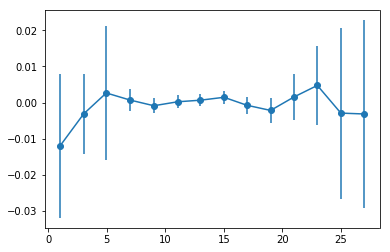

In [185]:
fig, ax = plt.subplots()
ax.scatter(f0s, fitsm['mode_freqs'].mean(axis=0) - f0s)
ax.errorbar(f0s, fitsm['mode_freqs'].mean(axis=0) - f0s, yerr=fitsm['mode_freqs'].std(axis=0))
print(fitsm['mode_freqs'].shape)
print(f0s.shape)

Here is a corner plot of the results:

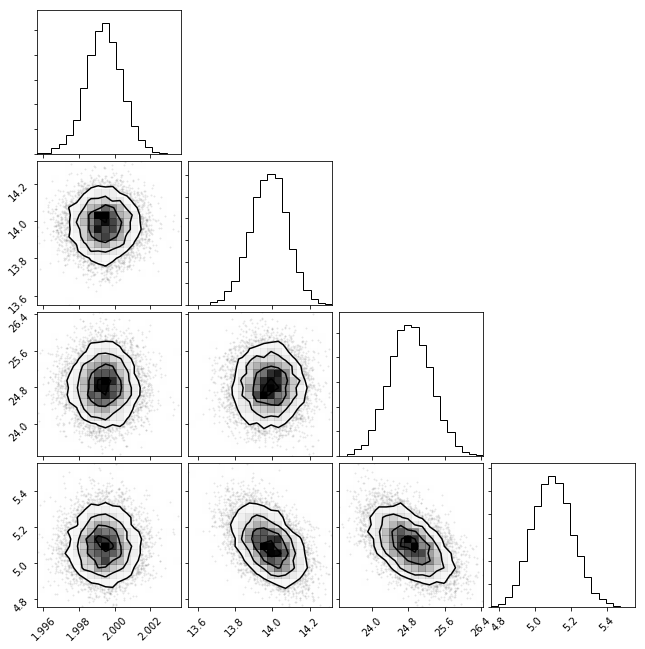

In [186]:
import corner
post = np.vstack([fitsm['dnu'], fitsm['numax'], fitsm['envheight'], fitsm['envwidth']]).T
corner.corner(post)
plt.show()

We can now compare the true model with the estimated model:

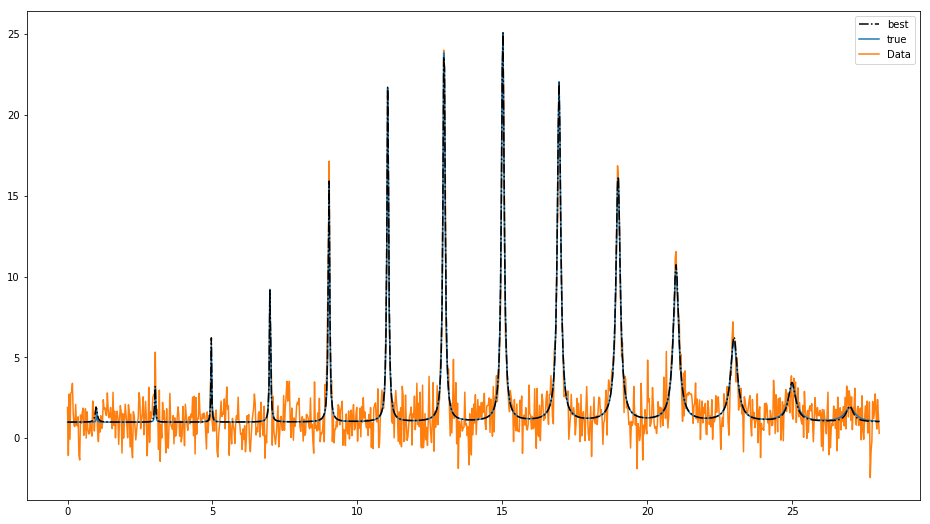

In [187]:
best = np.ones(len(f))
for idx, fff in enumerate(f0s):
    best += lor(f, fitsm['mode_freqs'].mean(axis=0)[idx], fitsm['modewidth'].mean(axis=0)[idx], 
                gaussian(fitsm['mode_freqs'].mean(axis=0)[idx], fitsm['numax'].mean(),
                            fitsm['envheight'].mean(), fitsm['envwidth'].mean())
                   )
fig, ax =plt.subplots(figsize=[16,9])
ax.plot(f, best, 'k-.', label='best', zorder=99)
ax.plot(f, true, label='true', zorder=98)
ax.plot(f, data, label='Data')
ax.legend()

This model works pretty well although things take a long time to converge.  Hopefully for the real data, good informative priors on the general mode properties will help convergence.

Note we will also have to use the proper chi squared two degrees of freedom noise of the real periodogram!

In [188]:
print(lw(f0s))
print(fitsm['modewidth'].mean(axis=0))
print(fitsm['modewidth'].std(axis=0))

[0.02239783 0.02825965 0.03531241 0.04460333 0.05636339 0.07118599
 0.08901409 0.11239648 0.14055608 0.17770292 0.22366504 0.28144139
 0.35471258 0.44614074]
[0.08185245 0.0389598  0.0282418  0.04122097 0.05962151 0.0738535
 0.08997809 0.11154639 0.13835073 0.17749658 0.22767673 0.27555132
 0.29903689 0.28507969]
[0.05063428 0.0179579  0.01015498 0.00557825 0.00381813 0.00320528
 0.00309953 0.0034279  0.00448176 0.00664847 0.01257966 0.02501562
 0.04736575 0.09088603]


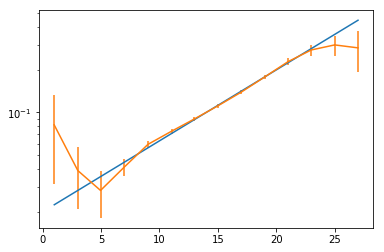

In [189]:
fig, ax = plt.subplots()
ax.errorbar(f0s, lw(f0s))
ax.errorbar(fitsm['mode_freqs'].mean(axis=0), fitsm['modewidth'].mean(axis=0),
           xerr=fitsm['mode_freqs'].std(axis=0), yerr=fitsm['modewidth'].std(axis=0))
ax.set_yscale('log')